In [4]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test
from feature_func import *

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [5]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

In [6]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

In [7]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

In [8]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

## The CCAO Dataset

This project works with the dataset from the Cook County Assessor's Office (CCAO) in Illinois. This government institution determines property taxes across most of Chicago's metropolitan areas and nearby suburbs. In the United States, all property owners must pay property taxes, which are then used to fund public services, including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models considering multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing "[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor's office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://fix8media-chicago.squarespace.com/bpnc-v-berrios-resource-page), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).



## Preparing Data


In [11]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general

np.random.seed(1337)


def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train_indicies = shuffled_indices[:int(data_len * 0.8)]
    test_indicies = shuffled_indices[int(data_len * 0.8):]
    
    train = data.iloc[train_indicies]
    validation = data.iloc[test_indicies]
   
    return train, validation
train, validation = train_val_split(training_val_data)

<br>

<hr style="border: 1px solid #fdb515;" />

Fitting our linear regression model using the ordinary least squares estimator. Features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

1st linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a 2nd model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

In [15]:
from feature_func import * 

###### Copy any function you would like to below ######
...
#######################################################


def process_data_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedroom column
    data = add_total_bedrooms(data)
    # Select X and Y from the full data
    X = data[['Bedrooms']]
    Y = data['Log Sale Price']
    return X, Y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model.
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, Y_train_m1_simple = process_data_simple(train_m1)
X_valid_m1_simple, Y_valid_m1_simple = process_data_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(Y_train_m1_simple.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [16]:
# Run this cell to define process_data_pipe; no further action is needed.
def process_data_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

In [17]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, Y_train_m1 = process_data_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, Y_valid_m1 = process_data_pipe(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by process_data_simple
display(X_train_m1.head())
display(Y_train_m1.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [18]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
train_m2, valid_m2 =  train_val_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Log Building Square Feet', 'Bedrooms'], None)
]

X_train_m2, Y_train_m2 = process_data_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, Y_valid_m2 = process_data_pipe(valid_m2, m2_pipelines, 'Log Sale Price')


# Take a look at the result
display(X_train_m2.head())
display(Y_train_m2.head())

,Log Building Square Feet,Bedrooms
130829,7.870166,4
193890,7.002156,2
30507,6.851185,2
91308,7.228388,2
131132,7.990915,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Initialized a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [20]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Fitted both models, and then used it to compute the fitted values of `Log Sale Price` over the training data, and the predicted values of `Log Sale Price` for the validation data.


- 1st Model: predicted values on **training set**: `Y_fitted_m1`, predicted values on **validation set**: `Y_predicted_m1`
- 2nd Model: predicted values on **training set**: `Y_fitted_m2`, predicted values on **validation set**: `Y_predicted_m2`

In [21]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, Y_train_m1)

# Compute the fitted and predicted values of Log Sale Price for 1st model
Y_fitted_m1 = linear_model_m1.predict(X_train_m1)
Y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, Y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for 2nd model
Y_fitted_m2 = linear_model_m2.predict(X_train_m2)
Y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

<br>

<hr style="border: 1px solid #fdb515;" />


Compare the performance of our two regression models using the Root Mean Squared Error (RMSE) function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$


In [23]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))


In the cell below, use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot the residuals from predicting `Log Sale Price` using **only the 2nd model** against the original `Log Sale Price` for the **validation data**. With such a large dataset, it is difficult to avoid overplotting entirely. You should also ensure that the dot size and opacity in the scatter plot are set appropriately to reduce the impact of overplotting as much as possible.

Text(0, 0.5, 'residual')

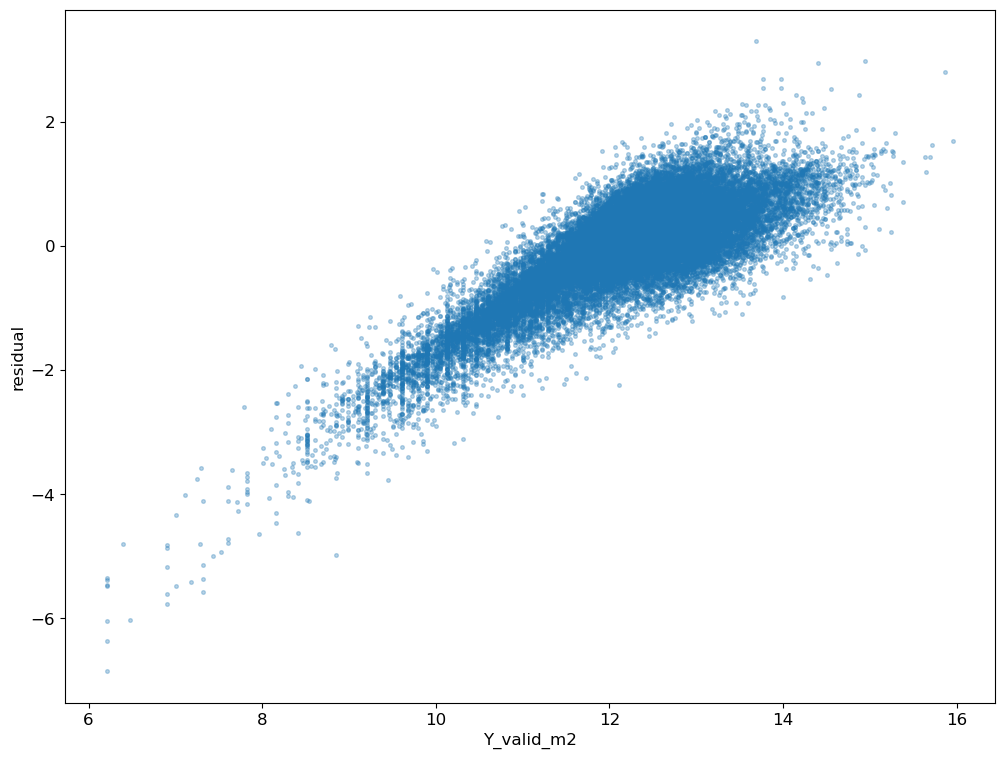

In [24]:
plt.scatter(y = Y_valid_m2-Y_predicted_m2, x = Y_valid_m2 ,alpha=0.3, s=7)
plt.xlabel("Y_valid_m2")
plt.ylabel("residual")

In [27]:
%reset -f                               
import otter                            
grader = otter.Notebook("projA2.ipynb")

# Imports all the necessary libraries again

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

from sklearn.preprocessing import OneHotEncoder

<br>

---

## Defining Pipeline Funtion


In [31]:
# Please include all of your feature engineering processes inside this function.
# Do not modify the parameters of this function.
from feature_func import *   

def log_cols(data, columns):
    for col in columns:
            data['Log '+col] = np.log(data[col], where = data[col]>0)
    return data
    
def exp_cols(data, columns, n):
    for col in columns:
        data['Exp '+col] = data[col] ** n
    return data 

def remove_outliers_perc(data, columns, low = 25, high = 75):
    for col in columns:
        low_end = np.percentile(data[col],low)
        high_end = np.percentile(data[col],high)
        data = remove_outliers(data,col,lower=low_end,upper=high_end)
    return data

    
def process_data_final(data, is_test_set=False):
    data = add_total_bedrooms(data)
    data = exp_cols(data,['Repair Condition'],n=3)
    data = log_cols(data,['Building Square Feet',
                         'Land Square Feet',
                         'Estimate (Land)'])

    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        data['Log Sale Price'] = np.log(data['Sale Price'])
        data = remove_outliers_perc(data, ['Sale Price',
                                           'Land Square Feet',
                                           'Estimate (Land)'])
        
        data = data[['Log Sale Price',
                     'Log Building Square Feet',
                     'Log Land Square Feet',
                     'Log Estimate (Land)',
                     'Exp Repair Condition',
                     'Bedrooms']]
        X = data.drop(['Log Sale Price'], axis = 1)
        Y = data.loc[:, 'Log Sale Price']
        return X,Y
                     
    else:
        # Processing for the test set
        # CANNOT involve references to sale price!
        # CANNOT involve removing any rows
        data = data[['Log Building Square Feet',
                     'Log Land Square Feet',
                     'Log Estimate (Land)',
                     'Exp Repair Condition',
                     'Bedrooms']]
        X = data
        return X
        
    # Processing for both test and training set
    # CANNOT involve references to sale price!
    # CANNOT involve removing any rows
    
    
    
    # Return predictors (X) and response (Y) variables separately
    if is_test_set:
        # Predictors 
        X = data[['Log Building Square Feet',
                     'Log Land Square Feet',
                     'Log Estimate (Land)',
                     'Exp Repair Condition',
                     'Bedrooms']]
        return X
    else:
        # Predictors. Your X should not include Log Sale Price!
        X = data[['Log Building Square Feet',
                     'Log Land Square Feet',
                     'Log Estimate (Land)',
                     'Exp Repair Condition',
                     'Bedrooms']]
        # Response variable
        Y = data.loc[:, 'Log Sale Price']
        
        return X, Y


# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)
print("You can check your grade for your prediction as per the grading scheme outlined at the start of Q5")

Current training RMSE: 62419.39859505616
You can check your grade for your prediction as per the grading scheme outlined at the start of Q5


<br>

<hr style="border: 1px solid #fdb515;" />

## Exploring RMSE


<br>

---

In [36]:
# Run the cell below; no further action is needed
train_df = pd.read_csv('cook_county_train.csv')
X, Y = process_data_final(train_df)
model = lm.LinearRegression(fit_intercept=True)
model.fit(X, Y)
Y_pred = model.predict(X)

In [37]:
# Run the cell below to obtain the two subsets of data; no further action is needed.
small_interval = (8, 11)
big_interval = (11, 14)
Y = pd.DataFrame(Y)
Y_small = Y[(Y['Log Sale Price'] > small_interval[0]) & (Y['Log Sale Price'] < small_interval[1])]['Log Sale Price']
Y_big = Y[(Y['Log Sale Price'] > big_interval[0]) & (Y['Log Sale Price'] < big_interval[1])]['Log Sale Price']
X_small = X.loc[Y_small.index]
X_big = X.loc[Y_big.index]

In [38]:
rmse_small = rmse(np.power(np.e, model.predict(X_small)),np.power(np.e,Y_small))
rmse_big = rmse(np.power(np.e,model.predict(X_big)),np.power(np.e,Y_big))

prop_overest_small = sum(Y_small < model.predict(X_small)) / len(Y_small)
prop_overest_big = sum(Y_big < model.predict(X_big)) / len(Y_big)

print(f"The RMSE for properties with log sale prices in the interval {small_interval} is {np.round(rmse_small)}")
print(f"The RMSE for properties with log sale prices in the interval {big_interval} is {np.round(rmse_big)}")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {small_interval} is {100 * np.round(prop_overest_small, 3)}%")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {big_interval} is {100 * np.round(prop_overest_big, 3)}%")

The RMSE for properties with log sale prices in the interval (8, 11) is 96754.0
The RMSE for properties with log sale prices in the interval (11, 14) is 60732.0
The percentage of overestimated values for properties with log sale prices in the interval (8, 11) is 100.0%
The percentage of overestimated values for properties with log sale prices in the interval (11, 14) is 38.9%


In [40]:
def rmse_interval(X, Y, start, end):
    '''
    Given a design matrix X and response vector Y, computes the RMSE for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval (start, end).

    Input: 
    X - 2D DataFrame representing the design matrix.
    Y - 1D DataFrame consisting of a single column labeled 'Log Sale Price'.
    start - A float specifying the start of the interval (exclusive).
    end - A float specifying the end of the interval (exclusive).
    '''
    
    
    Y_subset = Y[(Y['Log Sale Price'] > start) & (Y['Log Sale Price'] < end)]['Log Sale Price']
    X_subset = X.loc[Y_subset.index]

    # DO NOT MODIFY THESE TWO LINES
    if len(X_subset) == 0:
        return 0
        
    rmse_subset = rmse(np.power(np.e, model.predict(X_subset)),np.power(np.e, Y_subset))
    return rmse_subset
    
def prop_overest_interval(X, Y, start, end):
    '''
    Given a design matrix X and response vector Y, computes prop_overest for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval (start, end).

    Input: 
    X - 2D DataFrame representing the design matrix.
    Y - 1D DataFrame consisting of a single column labeled 'Log Sale Price'.
    start - A float specifying the start of the interval (exclusive).
    end - A float specifying the end of the interval (exclusive).
    '''
    
    Y_subset = Y[(Y['Log Sale Price'] > start) & (Y['Log Sale Price'] < end)]['Log Sale Price']
    X_subset = X.loc[Y_subset.index]

    # DO NOT MODIFY THESE TWO LINES
    if len(X_subset) == 0:
        return 0

    prop_subset = sum(Y_subset < model.predict(X_subset)) / len(Y_subset)
    return prop_subset

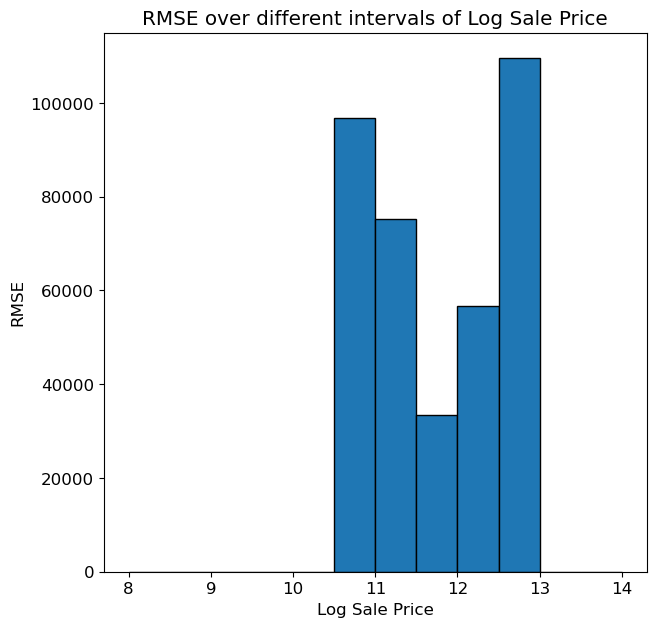

In [42]:
# Run the cell below to generate the plot; no further action is needed
rmses = []
for i in np.arange(8, 14, 0.5):
    rmses.append(rmse_interval(X, Y, i, i + 0.5))
plt.figure(figsize = (7, 7))
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = rmses, edgecolor = 'black', width = 0.5)
plt.title('RMSE over different intervals of Log Sale Price')
plt.xlabel('Log Sale Price')
plt.ylabel('RMSE');

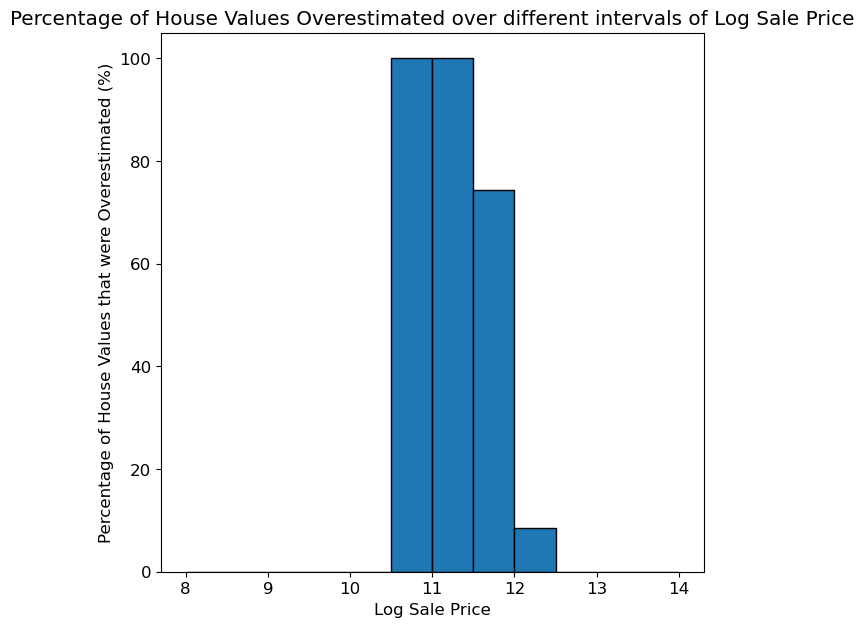

In [43]:
# Run the cell below to generate the plot; no further action is needed
props = []
for i in np.arange(8, 14, 0.5):
    props.append(prop_overest_interval(X, Y, i, i + 0.5) * 100)
plt.figure(figsize = (7, 7))
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = props, edgecolor = 'black', width = 0.5)
plt.title('Percentage of House Values Overestimated over different intervals of Log Sale Price')
plt.xlabel('Log Sale Price')
plt.ylabel('Percentage of House Values that were Overestimated (%)');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

<hr style="border: 1px solid #fdb515;" />

## Evaluating the Model in Context


When evaluating your model, we used RMSE. In the context of estimating the value of houses, what does the residual mean for an individual homeowner? How does it affect them in terms of property taxes? Discuss the cases where residual is positive and negative separately.

residual = actual y - predicted y

positive residual: the predicted value is smaller than the actual value, or the value of the house was underestimated. Therefore, the property tax would be lower than the tax based on the actual value. 

negative residual: the predicted value is bigger than the actual value, or the value of the house was overestimated. Therefore the property tax would be higher than the tax based on the actual value. 

<!-- END QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. Fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).


Accuracy does not necessarily mean fairness based on the case that we studied. A model with a lower RMSE might mean that the model has a value closer to actual values, but given that everyone has different circumstances and access to resources such as information, knowledge, or education, underprivileged people do not tend to receive a fair amount of opportunities. Although they technically have equal chances to contest their assessments or reduce tax by fixing overestimated values, some underprivileged people tend to not able to take advantage of such opportunities. Therefore, when it comes to assessing values of inexpensive properties, more effort has to be put or even should consider lowering taxes. 